In [1]:
using Optim
using Distributions

sin_curve(x) = g(t) = x[1] * sin(x[2] * t + x[3]) + x[4]

true_params = [10.0, 0.6, π, 80.0]
num_samples = 50
x_shift = π * rand(Float64)
x = [x_shift + (20 * i / num_samples) for i in -10:num_samples]
y = sin_curve(true_params).(x)

function cost_func(params)
  g = sin_curve(params)
  return sum((y - g.(x)) .^ 2)
end

function is_true_params(params::Vector{Float64}, tol::Union{Float64, Vector{Float64}} = 1e-3)
  if isa(tol, Float64)
    tol = tol * ones(length(true_params), 1)
  end
  return all(abs.(true_params - params) .<= tol)
end

max_runs = 100
success = 0
failed_param_set = []
for counter in 1:max_runs
  initial_values = [5 + 5 * rand(), rand(Uniform(0.42, 0.84)), rand(), 75];

  optimizer = NelderMead()
  result_nelder_mead = optimize(cost_func, initial_values, optimizer, Optim.Options(iterations=1000); autodiff = :forward)

  optimizer = ParticleSwarm(lower=[2.0, 0.42, 0.0, 40], upper=[13.0, 0.84, π, 140], n_particles=20) 
  result_particle_swarm = optimize(cost_func, initial_values, optimizer, Optim.Options(iterations=1000); autodiff = :forward)

  tol = [1e-2, 1e-4, 1e-3, 0.1]
  nelder_mead_success = is_true_params(result_nelder_mead.minimizer, tol)
  particle_swarm_success = is_true_params(result_particle_swarm.minimizer, tol)
  if nelder_mead_success && particle_swarm_success
    success += 1
  else
    if !nelder_mead_success && !particle_swarm_success
      display([
        initial_values,
        result_nelder_mead.minimizer,
        result_particle_swarm.minimizer
      ])
    end
    push!(failed_param_set, (result_nelder_mead.minimizer, result_particle_swarm.minimizer))
  end
  if counter % 50 == 0
    display("Convergence Rate $(round((100 * success) / counter, digits = 1))%")
  end
end
display("Final Convergence Rate $(round((100 * success) / max_runs, digits = 1))%")

"Convergence Rate 72.0%"

3-element Vector{Vector{Float64}}:
 [6.471235324318944, 0.4268624626139828, 0.235307588190652, 75.0]
 [10.000002979820522, 0.5999999390848492, -3.1415906851412623, 79.9999959711461]
 [2.0, 0.42, 0.0, 79.36612153251674]

"Convergence Rate 73.0%"

"Final Convergence Rate 73.0%"

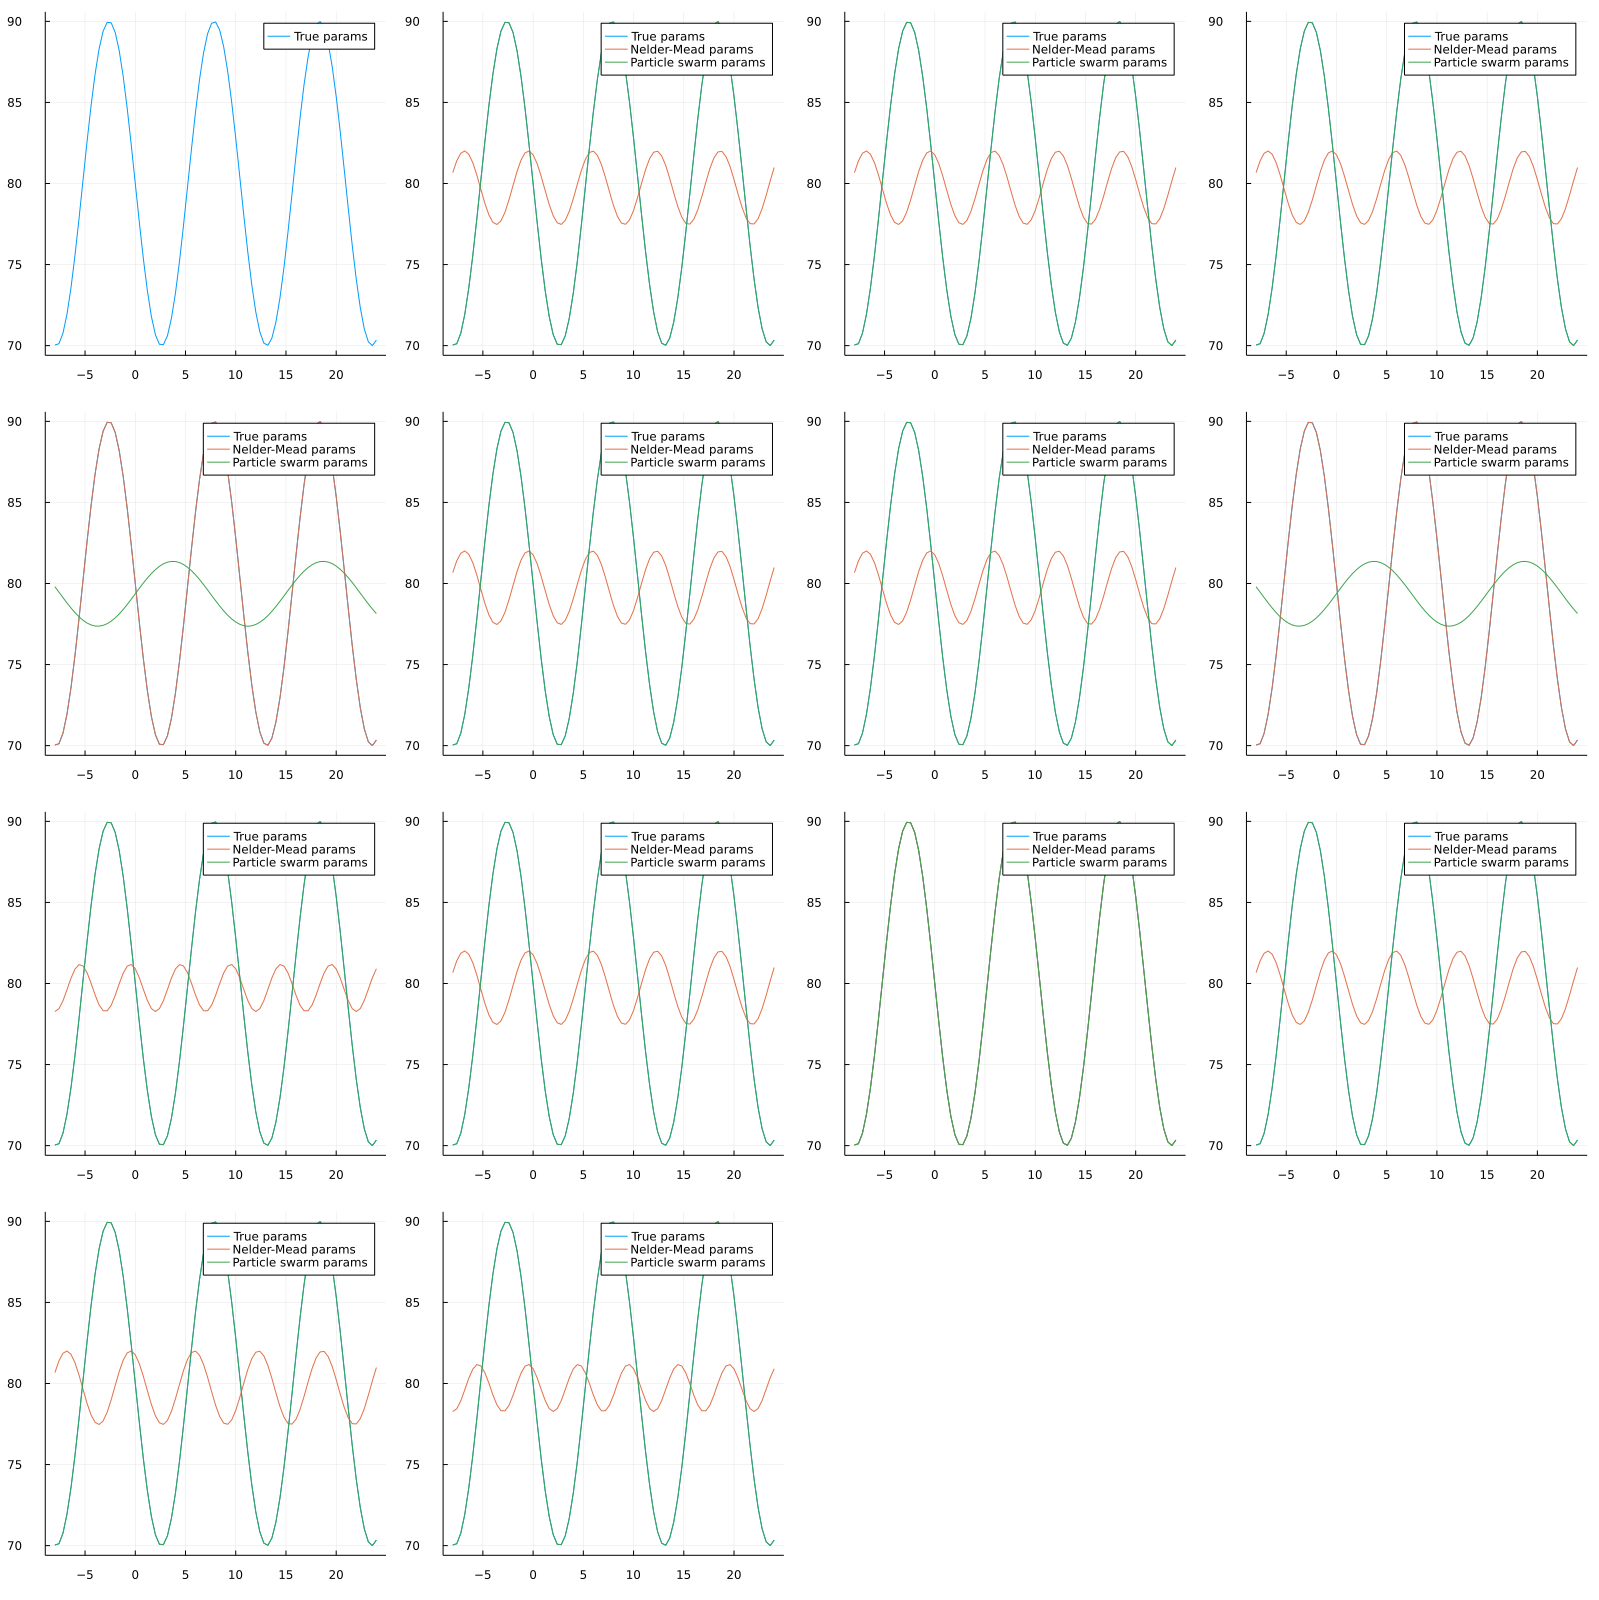

In [2]:
import Plots as plt


extended_x = [(20 * i / num_samples) for i in -20:num_samples + 10]
extended_y = sin_curve(true_params).(extended_x)
blankplot = plt.plot(legend=false, grid=false, foreground_color_subplot=:white)

function plot_true_and_predicted((nelder_mead_params, particle_swarm_params))
  plot = plt.plot(extended_x, extended_y; label="True params")

  predicted_y = sin_curve(nelder_mead_params).(extended_x)
  plot = plt.plot!(plot, extended_x, predicted_y; label="Nelder-Mead params")

  predicted_y = sin_curve(particle_swarm_params).(extended_x)
  plot = plt.plot!(plot, extended_x, predicted_y; label="Particle swarm params")
  return plot
end

function plot_subplots(subplots)
  prepend!(subplots, [plt.plot(extended_x, extended_y; label="True params")])
  N = 4
  M = ceil(Int64, length(subplots) / N)
  blank_subplots = repeat([deepcopy(blankplot)], M * N - length(subplots))
  plt.plot(
    subplots...,
    blank_subplots...,
    layout=plt.grid(M, N),
    size=(400, 400) .* (N, M)
  )
end

n_subplots = 12
start_idx = min(1, max(length(failed_param_set) - n_subplots, 1))
end_idx = min(start_idx + min(length(failed_param_set), n_subplots), length(failed_param_set))
plot_subplots(plot_true_and_predicted.(failed_param_set[start_idx:end_idx]))